# Notícias G1 - 10. Classificação com Deep Learning LSTM

Será feita a classificação das notícias de categoria desconhecida com base no modelo Long Short Term Memory.



## Imports:

Importes de bibliotecas usadas com frequência no código.

In [27]:
import pandas as pd
import numpy as np

## Recuperando Dados Gravados:

Recuperando dados gravados após cálculo de TF-IDF, criação de matrizes esparças e aplicação do One Hot Encoding.

In [28]:
df_tfidf_classificar = pd.read_csv("noticias_g1_tfidf_massa_classificar.csv")
df_tfidf_treino = pd.read_csv("noticias_g1_tfidf_massa_treino.csv")
df_tfidf_teste = pd.read_csv("noticias_g1_tfidf_massa_teste.csv")
df_cat_treino = pd.read_csv("noticias_g1_categorias_treino.csv")
df_cat_teste = pd.read_csv("noticias_g1_categorias_teste.csv")
df_one_hot_encoder = pd.read_csv('noticias_g1_one_hot_encoder.csv')
sm_one_hot_encoder = np.array(df_one_hot_encoder)

print(df_tfidf_classificar.shape, df_tfidf_treino.shape, 
      df_cat_treino.shape, df_tfidf_teste.shape, 
      df_cat_teste.shape, df_one_hot_encoder.shape)

(2111, 2494) (1206, 2494) (1206, 1) (517, 2494) (517, 1) (1206, 6)


## Tratando Desbalanceamento das Classes:

Como as classes estão muito desbalanceadas faremos o tratamento desse problema por meio do ajuste dos pesos para cada categoria. Isso será feito usando o sklearn.

In [29]:
from sklearn.utils import class_weight

y_integers = np.argmax(sm_one_hot_encoder, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 25.125,
 1: 0.43412526997840173,
 2: 7.178571428571429,
 3: 0.5726495726495726,
 4: 0.8854625550660793,
 5: 1.558139534883721}

## Transformando Labels em Números:

Cria uma coluna com o índice correspondente a cada classe no dataframe de categorias da amostra de teste.

In [30]:
index = 0
for category in df_one_hot_encoder.columns:
    df_cat_teste.loc[df_cat_teste['cat'] == category, 'index'] = index
    index = index + 1
df_cat_teste

,cat,index
0,politica,3.0
1,economia,1.0
2,economia,1.0
3,economia,1.0
4,politica,3.0
...,...,...
512,educacao,2.0
513,saude,5.0
514,economia,1.0
515,politica,3.0


## LSTM - Configuração:

Configura a rede para classificação com LSTM.

In [31]:
import tensorflow as tf

vocab_size = df_tfidf_treino.shape[1]
embedding_dim = 32

model = tf.keras.Sequential([

    # Add an embedding layer expecting input vocab and output embedding dimension
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    
    # Bidiretional layer with LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    
    # Add a Dense layer with softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          79808     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 98,726
Trainable params: 98,726
Non-trainable params: 0
_________________________________________________________________


## LSTM - Treinamento:

Realiza o treinamento para classificação com LSTM.

In [69]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    df_tfidf_treino,
    df_one_hot_encoder,
    batch_size=32,
    epochs = 5,
    #validation_data=(df_tfidf_teste, df_cat_teste['index']), 
    verbose = 2
)

Epoch 1/5
38/38 - 84s - loss: 0.1206 - accuracy: 0.3839
Epoch 2/5
38/38 - 84s - loss: 0.1205 - accuracy: 0.3839
Epoch 3/5
38/38 - 96s - loss: 0.1204 - accuracy: 0.3839
Epoch 4/5
38/38 - 89s - loss: 0.1203 - accuracy: 0.3839
Epoch 5/5
38/38 - 78s - loss: 0.1204 - accuracy: 0.3839


## Resultado do Treinamento:

Resultado apurado após o treinamento do modelo.

In [70]:
accr = model.evaluate(df_tfidf_teste, df_cat_teste['index'])
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 6s 316ms/step - loss: 8.5551 - accuracy: 0.0000e+00
Test set
  Loss: 8.555
  Accuracy: 0.000


KeyError: 'val_accuracy'

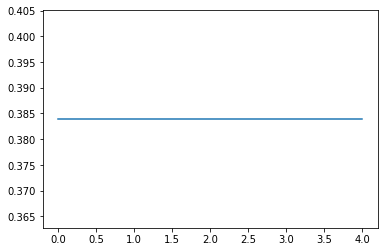

In [71]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Classificação da Massa de Teste:

Será realizado teste com a massa de dados separada para esse fim. Os resultados serão avaliados mais abaixo.

In [ ]:
categories = df_one_hot_encoder.columns
result = model.predict(df_tfidf_teste)
classificacao_massa_teste = []
for pred in result:
    classificacao_massa_teste.append(categories[np.argmax(pred)])
len(classificacao_massa_teste)

## Classificação da Base Desconhecida:

Classificação da massa de dados cuja categoria não conhecemos a partir do modelo treinado.

In [ ]:
# Classificação:
classification = model.predict(df_tfidf_classificar)

# Transformando índices em categorias legíveis:
classificacao_massa_desconhecida = []
for line in classification:
    classificacao_massa_desconhecida.append(categories[np.argmax(line)])
    
print(len(result))

## Análise dos Resultados: Distribuição por Categoria:

Elabora gráficos para comparar a distribuição dos dados na massa de treino, de teste, e de classificação (cuja categoria é desconhecida).

In [ ]:
# Calculando a distribuição:

from collections import Counter, OrderedDict

counter = sorted(Counter(np.append(df_cat_treino['cat'], ['Desconhecida'])).items(), key=lambda i: i[0])
dist_treino = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(np.append(df_cat_teste['cat'], ['Desconhecida'])).items(), key=lambda i: i[0])
dist_teste = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_teste).items(), key=lambda i: i[0])
dist_teste_ = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_desconhecida).items(), key=lambda i: i[0])
dist_classificacao = pd.DataFrame(counter, columns=['cat', 'qtd'])

print(dist_teste.shape, dist_teste_.shape, dist_classificacao.shape)

In [ ]:
import matplotlib.pyplot as plt

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

def pie(title, legend, data, label):
  fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
  ax.legend(wedges, label, title=legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
  plt.setp(autotexts, size=8, weight="bold")
  ax.set_title(title)
  plt.show()

pie("Treino: Classificação Real", "Categorias", dist_treino[['qtd']], dist_teste['cat'])
pie("Teste: Classificação Real", "Categorias", dist_teste[['qtd']], dist_teste['cat'])
pie("Teste: Classificação da Rede", "Categorias", dist_teste_[['qtd']], dist_teste_['cat'])
pie("Classificação Final", "Categorias", dist_classificacao[['qtd']], dist_classificacao['cat'])